In [1]:
import os
import shutil
import sys
import pickle

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgbm
from sklearn.metrics import mean_squared_error as mse

In [2]:
if not os.path.exists(r"./Features.py"):
    shutil.copyfile(r"../input/codejpx/Features.py", r"./Features.py")
if not os.path.exists(r"./Preprocessing.py"):
    shutil.copyfile(r"../input/codejpx/Preprocessing.py", r"./Preprocessing.py")
if not os.path.exists(r"./Trackers.py"):
    shutil.copyfile(r"../input/codejpx/Trackers.py", r"./Trackers.py")
if not os.path.exists(r"./Validation.py"):
    shutil.copyfile(r"../input/codejpx/Validation.py", r"./Validation.py")

In [3]:
import Features
from Preprocessing import StockDataPreprocessor
from Trackers import StateTracker

## Flags

In [4]:
load_train_data_flag = False
load_test_data_flag = False
save_train_data_flag = True
save_test_data_flag = True
train_model_flag = True
save_model_flag = False
check_features = False

## Load the Data

In [5]:
df_stocks = pd.read_csv(r'../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')

## Specify Features

In [6]:
features = [Features.Amplitude(), Features.OpenCloseReturn(), Features.Return(), 
            Features.Volatility(10), Features.Volatility(30), Features.Volatility(50), 
            Features.SMA("Close", 3), Features.SMA("Close", 5), Features.SMA("Close", 10),
            Features.SMA("Close", 30),
            Features.SMA("Return", 3), Features.SMA("Return", 5), 
            Features.SMA("Return", 10), Features.SMA("Return", 30),
           ]

### Check if training feature calculation and online feature calculation are consistent

In [7]:
if check_features is True:
    stock_id_to_check = np.random.choice(df_stocks["SecuritiesCode"].unique())
    print(f"Checking on {stock_id_to_check} for day 1")
    prices_to_check = df_stocks[df_stocks["SecuritiesCode"]==stock_id_to_check]
    prices_to_check = StockDataPreprocessor.preprocess_for_training(prices_to_check)

In [8]:
if check_features is True:
    prices_to_check.head()
    print(len(prices_to_check))

In [9]:
if check_features is True:
    features_copy = [feature.copy() for feature in features]
    Features.FeatureChecker.verify_features(features_copy, prices_to_check)

## Create training DataSet

In [10]:
st = StateTracker(features)

if load_train_data_flag is False:
    df_train = st.prepare_data_for_training(df_stocks)
else:
    df_train = pd.read_csv("../input/sampletraindataset/df_train.csv")

if save_train_data_flag is True:
    df_train.to_csv("df_train.csv")

In [11]:
st_sup = StateTracker([f.copy() for f in features])

if load_test_data_flag is False:
    df_stocks_sup = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")
    df_test = st_sup.prepare_data_for_training(df_stocks_sup)
else:
    df_test = pd.read_csv("../input/sampletraindataset/df_test.csv")
    
if save_test_data_flag is True:
    df_test.to_csv("df_test.csv")

In [12]:
## Specify training columns and specify categorical columns
training_cols = ['SecuritiesCode', 'Open', 'High', 'Low', 'Close',
                 'Volume', 'AdjustmentFactor', 'ExpectedDividend', 
                 'SupervisionFlag']

for feature in features:
    training_cols.append(feature.name)

categorical_cols = ["SecuritiesCode", "SupervisionFlag"]
target_col = ["Target"]

## Train/Load Model

In [26]:
if train_model_flag is True:
    print("Training...")
    lgbm_params = {}
    model = lgbm.LGBMRegressor(**lgbm_params)
    model.fit(df_train[training_cols], df_train[target_col], categorical_feature=categorical_cols, 
              eval_metric='rmse')
else:
    with open("../input/lgbm001/lgbm.pickle", "rb") as file:
        model = pickle.load(file)

training


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [ ]:
if save_model_flag is True:
    with open("./lgbm.pickle", "wb") as file:
        pickle.dump(model, file)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

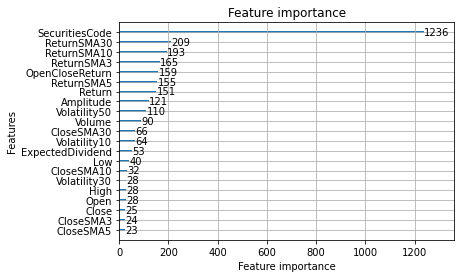

In [15]:
lgbm.plot_importance(model)

In [16]:
with open("../input/lgbm001/lgbm.pickle", "rb") as file:
        model1 = pickle.load(file)

In [17]:
model == model1

False

In [19]:
pred1 = model.predict(df_train[training_cols])

In [20]:
pred2 = model1.predict(df_train[training_cols])

In [24]:
(np.abs(pred1 - pred2) < 1e-5).all()

True